In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings

warnings.filterwarnings("ignore")

SEED = 42

In [2]:
import torch
import pickle
import pandas as pd
from sklearn.metrics import f1_score

In [3]:
embedders = [
    {'model': 'intfloat/multilingual-e5-base', 'model_ident': 'me5-base'},
    {'model': 'intfloat/multilingual-e5-large', 'model_ident': 'me5-large'},
    {'model': 'deutsche-telekom/gbert-large-paraphrase-cosine', 'model_ident': 't-gbert-lpc'}
]

classifiers = ['svc', 'rfc', 'mlp']

annotators = ["A001", "A002", "A003", "A004", "A005", "A007", "A008", "A009", "A010", "A012"]

In [4]:
def output_st1(predictions):
    #list with columns ["id": ..., "A001": "1.0, "A002": 0.0, "A003": ..., ..., "A012": ...] 
    QUANT_TO_QUAL={0: 0, 1: 1, 2: 1, 3: 1, 4: 1}
    NUMBER_TO_LABEL={0: "0-Kein", 1: "1-Gering", 2: "2-Vorhanden", 3: "3-Stark", 4: "4-Extrem"}

    #predictions_quant: pd.DataFrame = predictions.applymap(lambda x: LABEL_VALS_QUANT[x] if not pd.isna(x) else x)
    predictions_qual: pd.DataFrame = predictions.applymap(lambda x: QUANT_TO_QUAL[x] if not pd.isna(x) else x)

    output = pd.DataFrame(index=["id"])
    output.index = predictions.index

    #create expected columns
    output["bin_maj"] = predictions_qual.mode(axis='columns')[0]
    output["bin_one"] = predictions_qual.apply(lambda x: (x == 1).any(), axis='columns')
    output["bin_all"] = predictions_qual.apply(lambda x: not (x == 0).any(), axis='columns')
    output["multi_maj"] = predictions.mode(axis='columns')[0].apply(lambda x: NUMBER_TO_LABEL[x])
    output["disagree_bin"] = output.apply(lambda x: x["bin_one"] and not x["bin_all"], axis='columns')

    #convert False/True to 0/1
    output['bin_maj'] = output['bin_maj'].apply(lambda x: 1 if x else 0)
    output['bin_one'] = output['bin_one'].apply(lambda x: 1 if x else 0)
    output['bin_all'] = output['bin_all'].apply(lambda x: 1 if x else 0)
    output['disagree_bin'] = output['disagree_bin'].apply(lambda x: 1 if x else 0)

    return output

In [5]:
y_val = pd.read_json("created_data/training_data/y_val.jsonl", lines=True).set_index('id')

scoring=pd.DataFrame(index = [e['model_ident'] for e in embedders], columns=classifiers)

for embedder in embedders:
    embeddings = pd.read_pickle(f"created_data/embeddings/{embedder['model_ident']}.pkl")
    X_val = embeddings.loc[y_val.index]

    for classifier in classifiers:

        classifier_models = {}
        for annotator in annotators:
            with open(f"models/{embedder['model_ident']}_{classifier}_{annotator}.pkl", 'rb') as f:
                model = pickle.load(f)
            classifier_models[annotator] = model

        pred = pd.DataFrame(index=X_val.index, columns=annotators)

        for idx, row in X_val.iterrows():
            correct_annos = y_val.loc[idx].dropna().index
            for anno in correct_annos:
                pred[anno].loc[idx] = classifier_models[anno].predict([row['Embedding']])[0]

        output_correct = output_st1(y_val)
        output_predicted = output_st1(pred)

        col_scorings = []
        for col in output_correct.columns:
            col_scorings.append(f1_score(output_correct[col], output_predicted[col], average='macro'))
        print(f"{embedder['model_ident']}-{classifier}: {col_scorings}")
        scoring.loc[embedder['model_ident']][classifier] = sum(col_scorings) / len(col_scorings)

me5-base-svc: [0.6527394240257944, 0.7321156773211568, 0.5590292060880296, 0.2926679854022387, 0.6038095238095238]
me5-base-rfc: [0.4036114639129714, 0.4847443928066276, 0.45355191256830596, 0.16699029126213594, 0.499810534293293]
me5-base-mlp: [0.705103509803524, 0.7183671016139511, 0.6174218271579996, 0.31935607350281014, 0.592391304347826]
me5-large-svc: [0.6854113513182064, 0.7528069331370686, 0.5914198161389173, 0.27347935338196755, 0.6330288248337028]
me5-large-rfc: [0.409, 0.5496586121737446, 0.45355191256830596, 0.16718446601941744, 0.5325069141244683]
me5-large-mlp: [0.704651735171056, 0.7597130189531327, 0.616443116383288, 0.2897623321316701, 0.624285291021301]
t-gbert-lpc-svc: [0.6616989524790944, 0.7470430965932215, 0.5353545280330204, 0.25541339819600684, 0.6253876442714055]
t-gbert-lpc-rfc: [0.4179185306986575, 0.5595584798475532, 0.45355191256830596, 0.17111951253953156, 0.5411706349206349]
t-gbert-lpc-mlp: [0.6918097645117345, 0.7409440451713103, 0.5859094176851186, 0.2

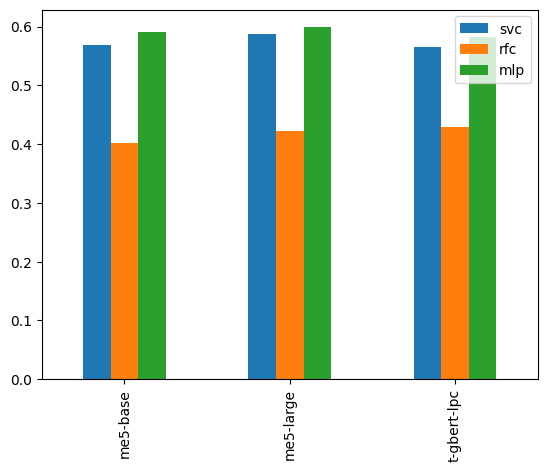

,svc,rfc,mlp
me5-base,0.568072,0.401742,0.590528
me5-large,0.587229,0.42238,0.598971
t-gbert-lpc,0.56498,0.428664,0.58269


In [6]:
from matplotlib import pyplot as plt

scoring.plot(kind="bar")
plt.show()
scoring